**Трофимов Михаил ПМ22-1**

# Лабораторная работа 2. Классификация изображений

In [1]:
!pip install torchmetrics >> None
!pip install torchvision >> None

In [2]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchmetrics as M
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import torchvision.models as models
import copy

In [3]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as archive:
    archive.extractall()

In [4]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root = 'data', transform = transform)

dataset_loader = DataLoader(dataset, batch_size = 8)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
n = len(dataset) * 64 * 64

mu = th.zeros((3,), dtype=th.float)
sig = th.zeros((3,), dtype=th.float)

for batch, _ in dataset_loader:
    for data in batch:
        mu += data.sum(dim = 1).sum(dim = 1)
        sig += (data**2).sum(dim = 1).sum(dim = 1)

mu = mu / n
sig = th.sqrt(sig / n - mu**2)

mu, sig

(tensor([0.4383, 0.4703, 0.4363]), tensor([0.1832, 0.1539, 0.2062]))

In [6]:
transform_new = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean = mu, std = sig)
])

dataset = torchvision.datasets.ImageFolder(root = 'data', transform = transform_new)

print(f'Картинок в датасете: {len(dataset)}')
print(f'Количество классов: {len(dataset.classes)}')
print(f'Размер картинки: {dataset[0][0].shape}')

th.manual_seed(42)
train, test = random_split(dataset, [0.8, 0.2])
cti = dataset.class_to_idx

Картинок в датасете: 2226
Количество классов: 4
Размер картинки: torch.Size([3, 64, 64])


In [7]:
def train_model(model, criterion, optimizer, metric, file_name, train, test, batch_size, num_epoch):
    th.manual_seed(42)

    loader = DataLoader(train, batch_size = batch_size)
    loader_test = DataLoader(test, batch_size = batch_size)

    model = model.to('cuda')
    criterion = criterion.to('cuda')
    metric = metric.to('cuda')

    best_metric = 0
    epoch_losses = []
    test_metrics = []

    for epoch in tqdm(range(num_epoch), desc = 'Обучение'):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(loader)
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            for X_batch, y_batch in loader_test:
                X_batch = X_batch.to('cuda')
                y_batch = y_batch.to('cuda')
                y_pred = model(X_batch).argmax(dim = 1)
                metric.update(y_pred, y_batch)

        test_metric = metric.compute().cpu().item()
        test_metrics.append(test_metric)

        if test_metric > best_metric:
            best_metric = test_metric
            th.save(model, file_name)

    return epoch_losses, test_metrics

In [8]:
def show_image(image, file_name, classes_to_idx, mean, std):
    model = th.load(file_name, weights_only = False).to('cuda')
    model.eval()

    true_label = image[1]
    image_tensor = image[0].to('cuda')

    with th.no_grad():
        pred_idx = model(image_tensor.unsqueeze(0)).argmax(dim=1).item()

    idx_to_class = {v: k for k, v in classes_to_idx.items()}
    pred_class = idx_to_class[pred_idx]
    true_class = idx_to_class[true_label]

    image_np = image_tensor.cpu().numpy().transpose((1, 2, 0))
    image_np = std * image_np + mean

    plt.title(f'Predict: {pred_class} | True: {true_class}')
    plt.imshow(image_np)
    plt.show()

## Задание 1

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) взять два класса и построить модель бинарной классификации, постараться улучшить точность модели. Построить графики кривых обучения.

*Локально удалил классы Apple___Cedar_apple_rust (275) и Apple___healthy (700). Оставшиеся классы сбалансированы - буду использовать метрику Accuracy*

In [9]:
with zipfile.ZipFile('data_bin.zip', 'r') as archive:
    archive.extractall()

transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(root = 'data_bin', transform = transform)
dataset_loader = DataLoader(dataset, batch_size = 8)

n = len(dataset) * 64 * 64
mu_bin = th.zeros((3,), dtype=th.float)
sig_bin = th.zeros((3,), dtype=th.float)
for batch, _ in dataset_loader:
    for data in batch:
        mu_bin += data.sum(dim = 1).sum(dim = 1)
        sig_bin += (data**2).sum(dim = 1).sum(dim = 1)
mu_bin = mu_bin / n
sig_bin = th.sqrt(sig_bin / n - mu_bin**2)

transform_new = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean = mu_bin, std = sig_bin)
])
dataset = torchvision.datasets.ImageFolder(root = 'data_bin', transform = transform_new)
print(f'Картинок в датасете: {len(dataset)}')
print(f'Количество классов: {len(dataset.classes)}')
print(f'Размер картинки: {dataset[0][0].shape}')

th.manual_seed(42)
train_bin, test_bin = random_split(dataset, [0.8, 0.2])
cti_bin = dataset.class_to_idx

Картинок в датасете: 1251
Количество классов: 2
Размер картинки: torch.Size([3, 64, 64])


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(2048, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.Accuracy(task = 'binary')

epoch_losses, accuracy_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                          metric = metric, file_name = 'n1.pth', train = train_bin,
                                          test = test_bin, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


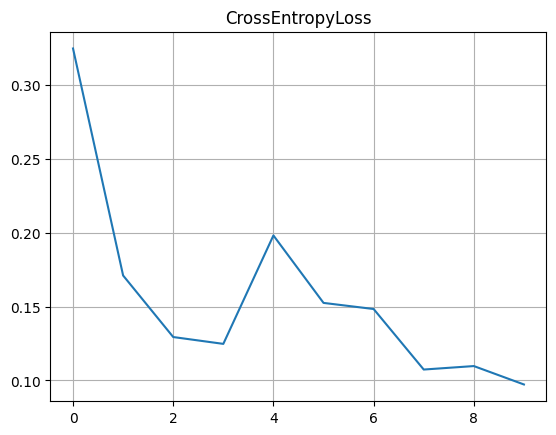

In [12]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

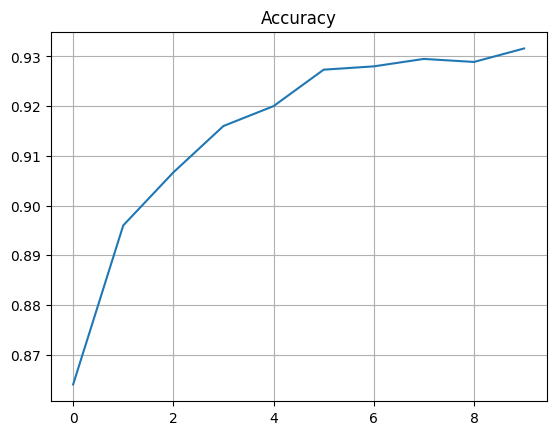

In [13]:
plt.title('Accuracy')
plt.plot(accuracy_test)
plt.grid(True)
plt.show()

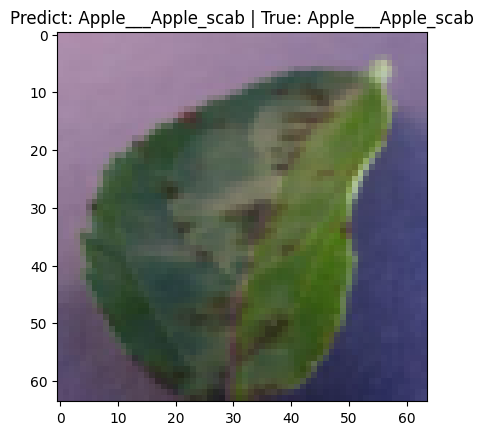

In [14]:
choice = randint(0, len(test_bin))
show_image(test_bin[choice], 'n1.pth', cti_bin, mu_bin, sig_bin)

## Задание 2

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) построить модель многоклассовой классификации, постараться улучшить точность модели. Построить графики кривых обучения.

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(2048, 4)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

epoch_losses, f1_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                    metric = metric, file_name = 'n2.pth', train = train,
                                    test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


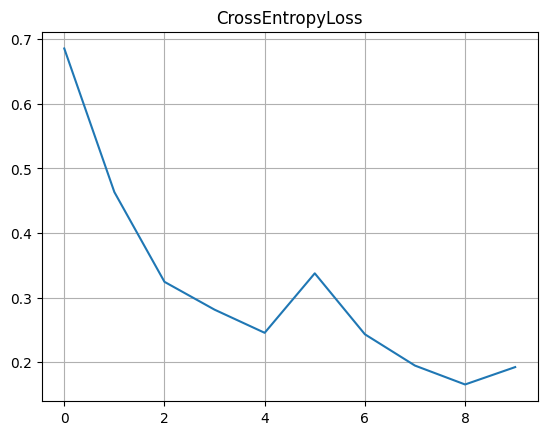

In [17]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

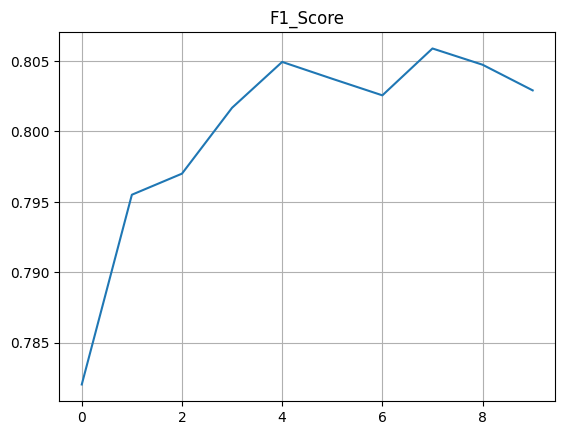

In [18]:
plt.title('F1_Score')
plt.plot(f1_test)
plt.grid(True)
plt.show()

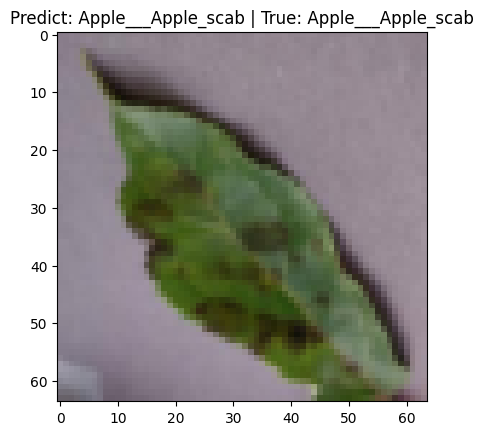

In [19]:
choice = randint(0, len(test))
show_image(test[choice], 'n2.pth', cti, mu, sig)

In [20]:
model = CNN()
criterion = nn.CrossEntropyLoss(weight = (1 / th.tensor([630, 621, 275, 700])) / 2226)
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

epoch_losses, f1_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                    metric = metric, file_name = 'n2_weights.pth', train = train,
                                    test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


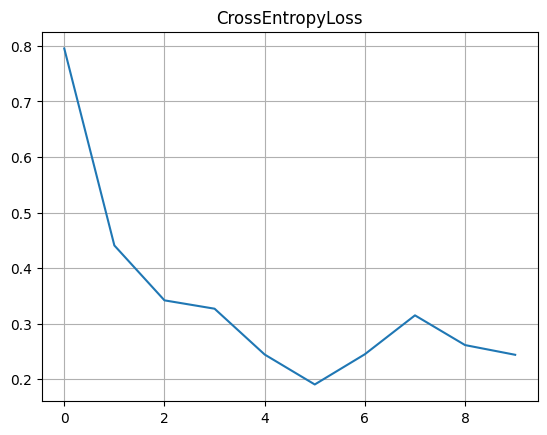

In [21]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

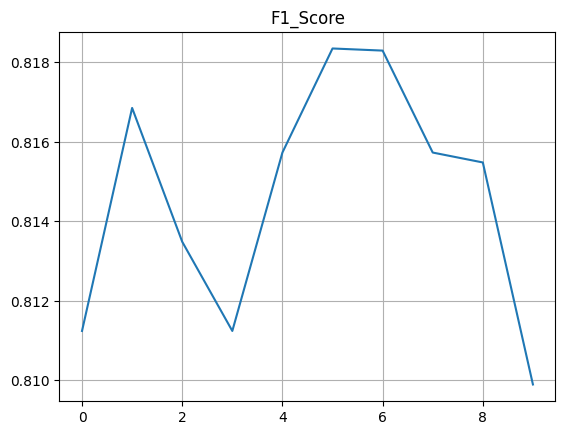

In [22]:
plt.title('F1_Score')
plt.plot(f1_test)
plt.grid(True)
plt.show()

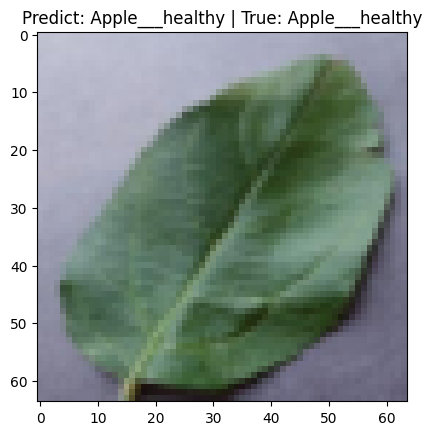

In [23]:
choice = randint(0, len(test))
show_image(test[choice], 'n2_weights.pth', cti, mu, sig)

## Задание 3

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) изучить зависимость точности модели от количества слоев. Построить графики кривых обучения и интерпретировать.

In [24]:
class CNN_1block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(5766, 4)

    def forward(self, X):
        return self.fc(self.conv(X).flatten(start_dim = 1))

In [25]:
model = CNN_1block()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_1block, f1_1block = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                       metric = metric, file_name = 'n3_1b.pth', train = train,
                                       test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


In [26]:
class CNN_2block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 12, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(2352, 4)

    def forward(self, X):
        return self.fc(self.conv(X).flatten(start_dim = 1))

In [27]:
model = CNN_2block()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_2block, f1_2block = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                       metric = metric, file_name = 'n3_2b.pth', train = train,
                                       test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


In [28]:
class CNN_3block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 12, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 24, 3, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(864, 4)

    def forward(self, X):
        return self.fc(self.conv(X).flatten(start_dim = 1))

In [29]:
model = CNN_3block()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_3block, f1_3block = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                       metric = metric, file_name = 'n3_3b.pth', train = train,
                                       test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


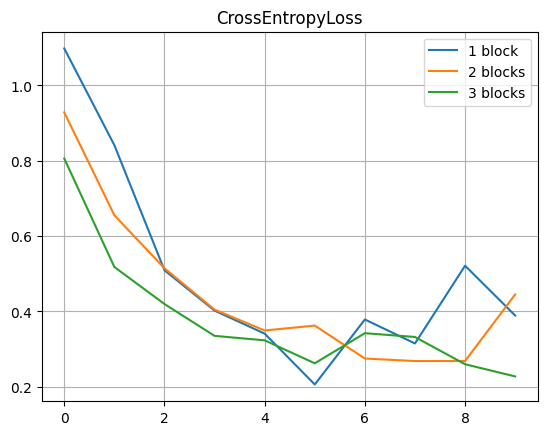

In [30]:
plt.title('CrossEntropyLoss')
plt.plot(losses_1block, label = '1 block')
plt.plot(losses_2block, label = '2 blocks')
plt.plot(losses_3block, label = '3 blocks')
plt.legend()
plt.grid(True)
plt.show()

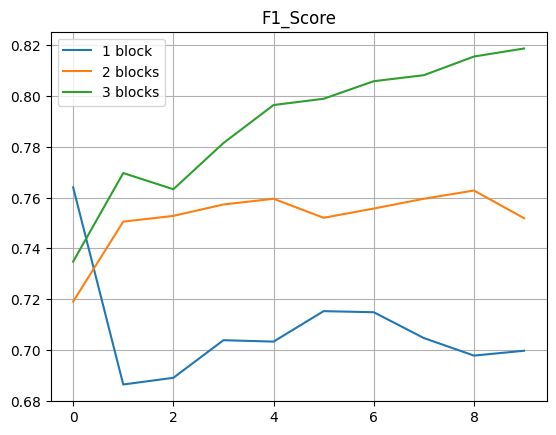

In [31]:
plt.title('F1_Score')
plt.plot(f1_1block, label = '1 block')
plt.plot(f1_2block, label = '2 blocks')
plt.plot(f1_3block, label = '3 blocks')
plt.legend()
plt.grid(True)
plt.show()

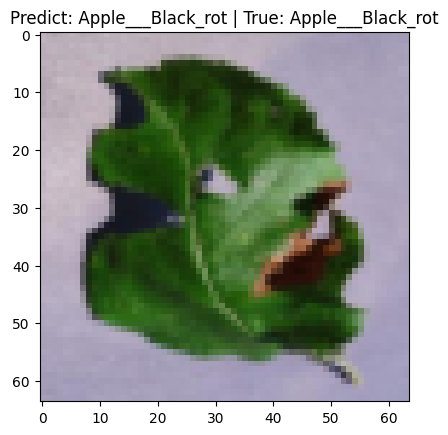

In [32]:
choice = randint(0, len(test))
show_image(test[choice], 'n3_3b.pth', cti, mu, sig)

## Задание 4

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) провести обучение с переносом, используя обученную сеть (например, VGG16) Изучить влияние точности модели от количества добавляемых новых слоев. Построить графики кривых обучения для каждого случая в TensorBoard.

In [33]:
model = models.mobilenet_v2(
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1)

for p in model.parameters():
    p.requires_grad_(False)

model.classifier

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 126MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [34]:
model.classifier[-1] = nn.Linear(in_features = 1280, out_features = 4)
print(f'Число настраиваемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad == True)}')

Число настраиваемых параметров: 5124


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_1, f1_1 = train_model(model = model, criterion = criterion, optimizer = optimizer,
                             metric = metric, file_name = 'n4_1.pth', train = train,
                             test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


In [36]:
model2 = copy.deepcopy(model)
model2.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 4))

print(f'Число настраиваемых параметров: {sum(p.numel() for p in model2.parameters() if p.requires_grad == True)}')

Число настраиваемых параметров: 82244


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_2, f1_2 = train_model(model = model2, criterion = criterion, optimizer = optimizer,
                             metric = metric, file_name = 'n4_2.pth', train = train,
                             test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


In [38]:
model3 = copy.deepcopy(model)
model3.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 4))

print(f'Число настраиваемых параметров: {sum(p.numel() for p in model3.parameters() if p.requires_grad == True)}')

Число настраиваемых параметров: 86404


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
metric = M.F1Score(task = 'multiclass', num_classes = 4)

losses_3, f1_3 = train_model(model = model3, criterion = criterion, optimizer = optimizer,
                             metric = metric, file_name = 'n4_3.pth', train = train,
                             test = test, batch_size = 8, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


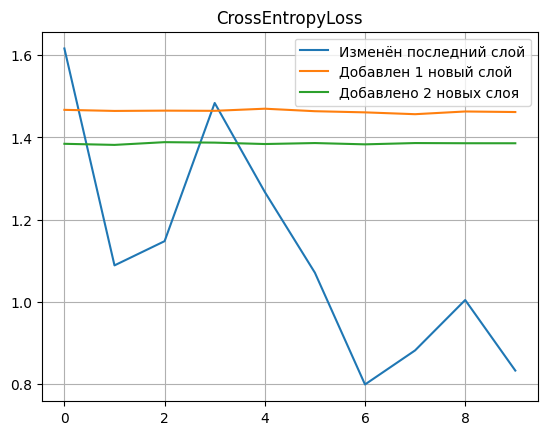

In [40]:
plt.title('CrossEntropyLoss')
plt.plot(losses_1, label = 'Изменён последний слой')
plt.plot(losses_2, label = 'Добавлен 1 новый слой')
plt.plot(losses_3, label = 'Добавлено 2 новых слоя')
plt.legend()
plt.grid(True)
plt.show()

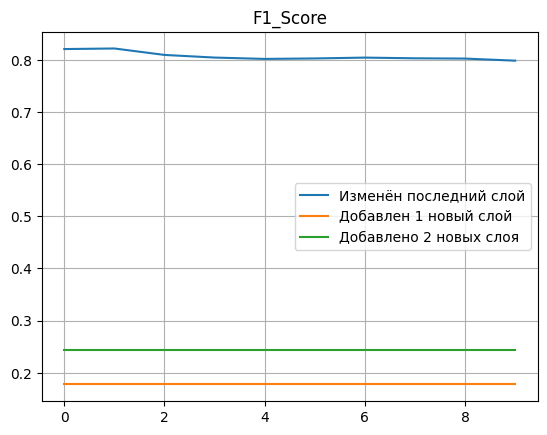

In [41]:
plt.title('F1_Score')
plt.plot(f1_1, label = 'Изменён последний слой')
plt.plot(f1_2, label = 'Добавлен 1 новый слой')
plt.plot(f1_3, label = 'Добавлено 2 новых слоя')
plt.legend()
plt.grid(True)
plt.show()

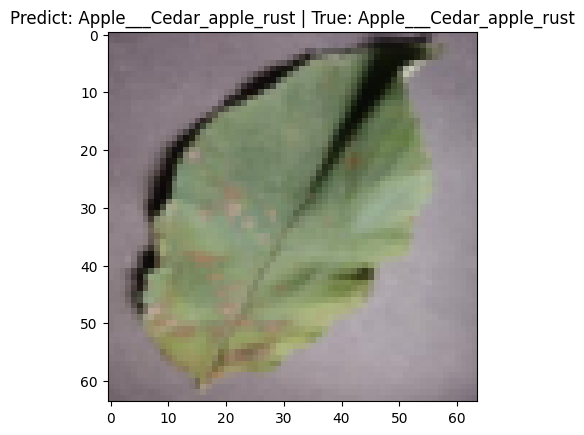

In [42]:
choice = randint(0, len(test))
show_image(test[choice], 'n4_1.pth', cti, mu, sig)